In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
%matplotlib inline

from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/cleveland.csv", header=None, error_bad_lines=False)

# Define the features and the outcome.
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace missing values (marked by ?) with a 0.
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis.
y = np.where(y > 0, 0, 1)

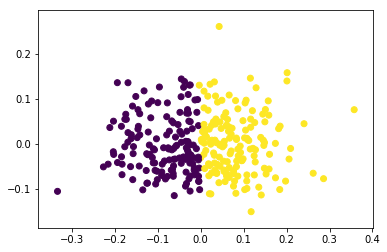

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0      84  65
1      55  99


In [3]:
#%%timeit -n1 -r1
# Normalize the data.
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

In [4]:
%%timeit -n1 -r1
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=2,
    batch_size=200,
    random_state=7)

minibatchkmeans.fit(X_pca)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X_pca)

# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, y_pred))

Comparing k-means and mini batch k-means solutions:
col_0    0    1
row_0          
0      148    0
1        1  154
25.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Really not sure what is wrong with the %%timeit magic function.  I have to run the first kmeans cell before adding the %%timeit to get the second cell to recognize that any of the variables have been initialized.

Also the second kminimeans is either perfectly accurate (almost) or perfectly inaccurate after each time the cell is run, setting the random_state to avoid this.

## Play around with changing K

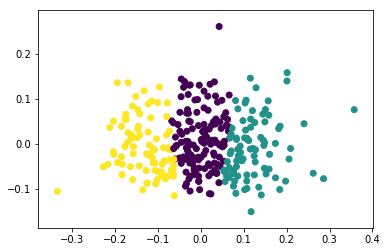

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0      65  70
1      25  61
2      49  33
133 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [5]:
%%timeit -n1 -r1
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

In [6]:
%%timeit -n1 -r1
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=4,
    batch_size=200,
    random_state=7)

minibatchkmeans.fit(X_pca)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X_pca)

# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, y_pred))

Comparing k-means and mini batch k-means solutions:
col_0   0   1
row_0        
0      63   0
1       9  49
2      77  26
3       0  79
28.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


The solution that I find the most compelling is the MiniBatchKmeans, with a random_state=7 where it is almost perfect.  I am not sure why I would want to increase the number of clusters for a binary case.  Would I be looking to see that they perfectly predict, or atleast come close to predicting, one of the binary values to determine whether or not that cluster is worth keeping?  For example if I went with the 4 clusters in the MiniBatchKmeans would cluster 0 and 2 be the ones that are predicting 'not heart disease' (with 2 not being that great) and then 1 and 3 predicting the 'heart disease'.

# Other Methods - Mean-shift, Spectral Clustering, Affinity Propagation

### Mean-shift

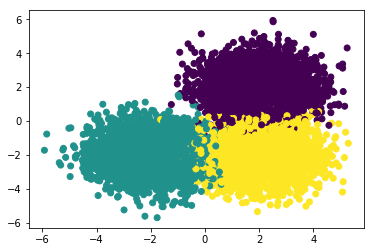

In [7]:
# The coordinates of the centers of our blobs.
centers = [[2, 2], [-2, -2], [2, -2]]

# Make 10,000 rows worth of data with two features representing three
# clusters, each having a standard deviation of 1.
X, y = make_blobs(
    n_samples=10000,
    centers=centers,
    cluster_std=1,
    n_features=2,
    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

#Divide into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.9,
    random_state=42)

In [27]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_
#print(cluster_centers)

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

[[ 2.04295972  1.95044321]
 [ 2.04047398 -1.77365853]
 [-1.82083159 -2.04143861]]
Number of estimated clusters: 3


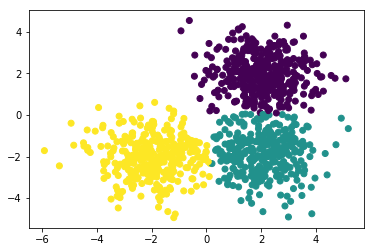

Comparing the assigned categories to the ones in the data:
col_0    0    1    2
row_0               
0      352   10    0
1        1    8  311
2        6  304    8


In [9]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,labels))

The mean-shift seems to be able to identify each cluster but almost completely swapped the 1 and 2 clusters.

### Spectral Clustering

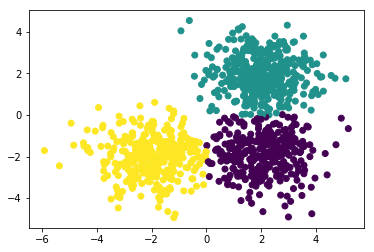

Comparing the assigned categories to the ones in the data:
col_0    0    1    2
row_0               
0        5  357    0
1        9    1  310
2      306    7    5


In [12]:
from sklearn.cluster import SpectralClustering

# We know we're looking for three clusters.
n_clusters=3

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train)

#Predicted clusters.
predict=sc.fit_predict(X_train)

#Graph results.
plt.scatter(X_train[:, 0], X_train[:, 1], c=predict)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,predict))

The two dots that were concerning in the thinkful set are matched correctly here.  Again all of the clusters are incorrectly identified.

### Affinity Propagation

In [13]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

# Declare the model and fit it in one statement.
# Note that you can provide arguments to the model, but we didn't.
af = AffinityPropagation().fit(X_train)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

Done
Estimated number of clusters: 93


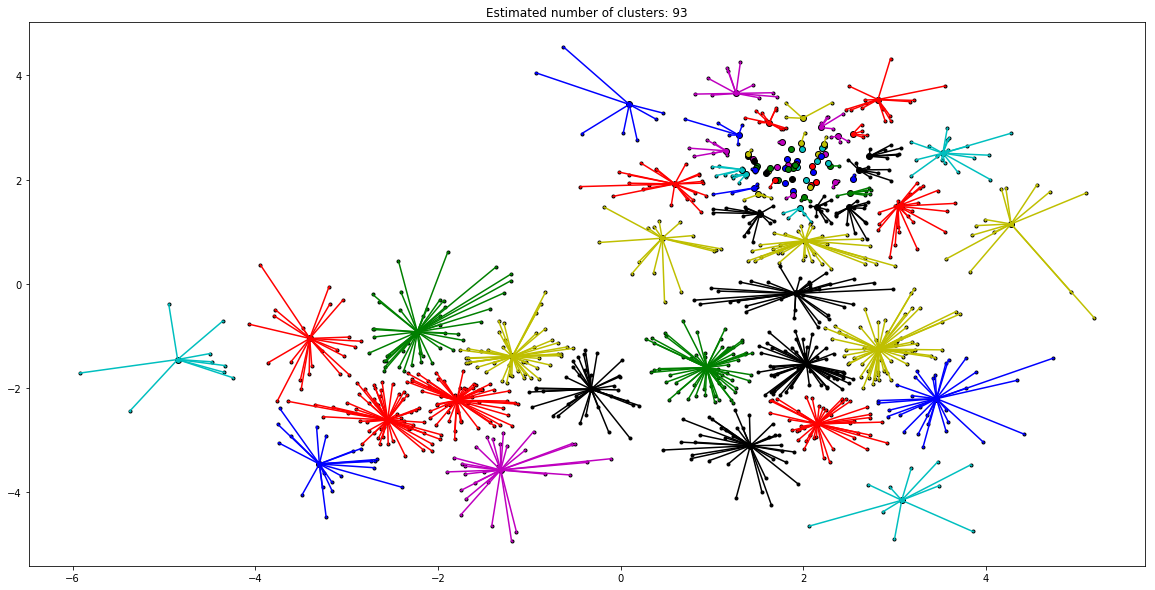

In [16]:
from itertools import cycle

plt.figure(1,figsize=(20,10))
plt.clf()

# Cycle through each cluster and graph them with a center point for the
# exemplar and lines from the exemplar to each data point in the cluster.
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_train[cluster_centers_indices[k]]
    plt.plot(X_train[class_members, 0], X_train[class_members, 1], col + '.', markeredgecolor='k')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=col,
             markeredgecolor='k')
    for x in X_train[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: {}'.format(n_clusters_))
plt.show()

# DRILL: Mo' blobs, mo' problems?
### Set up at least three different blob configuations, then run the four methods (k -means, mean shift, spectral clustering and affinity propagation) on each one.

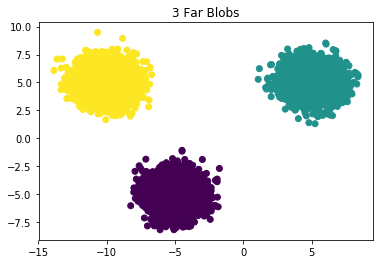

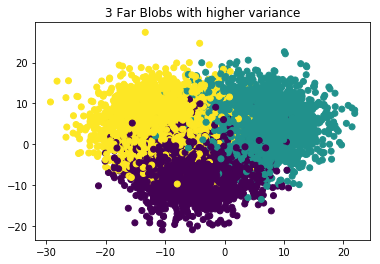

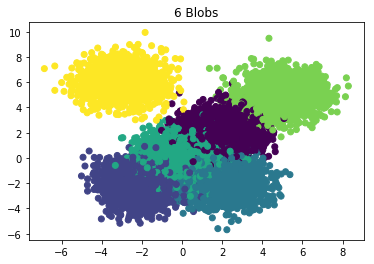

In [33]:
def blob_setup(center, std):
    X, y = make_blobs(
        n_samples=10000,
        centers=center,
        cluster_std=std,
        n_features=2, # keep this so that we can still plot in 2-D
        random_state=42)
    return X,y

# Increase distance between blobs
far_blobs_center = [[-5,-5], [5,5], [-10,5]]

farx, fary = blob_setup(far_blobs_center, 1)
plt.scatter(farx[:, 0], farx[:, 1], c=fary)
plt.title('3 Far Blobs')
plt.show()

# Increase std for far blobs
far_blobs_center_hivar = [[-5,-5], [5,5], [-10,5]]

far_hivarx, far_hivary = blob_setup(far_blobs_center_hivar, 5)
plt.scatter(far_hivarx[:, 0], far_hivarx[:, 1], c=far_hivary)
plt.title('3 Far Blobs with higher variance')
plt.show()

# More blobs
more_centers = [[2, 2], [-2, -2], [2, -2], [0,0], [5,5], [-3, 6]]
morex, morey = blob_setup(more_centers, 1)
plt.scatter(morex[:, 0], morex[:, 1], c=morey)
plt.title('6 Blobs')
plt.show()

In [45]:
def clusters(x, y, n):
    # Sample down - use only 10% of data for 
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.9, random_state=42)
    
    #################### KMeans ####################
    
    # Calculate predicted values for KMeans.
    y_predkm = KMeans(n_clusters=n, random_state=42).fit_predict(X_train)

    # Plot the KMeans solution.
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_predkm)
    plt.title('KMeans', fontsize=20)
    plt.show()

    # Check the solution against the data.
    print('Comparing k-Means clusters against the data:')
    print(pd.crosstab(y_train, y_predkm))
    print('='*75)
    
    #################### Mean Shift ####################
    
    # Set bandwith
    bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=500)

    # Declare and fit the model.
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(X_train)

    # Extract cluster assignments for each data point.
    labels_ms = ms.labels_

    # Count our clusters.
    n_clusters_ms = len(np.unique(labels_ms))

    print("Number of estimated clusters in Mean-Shift: {}".format(n_clusters_ms))
    print('-'*75)
    
    # Plot the Mean Shift solution.
    plt.scatter(X_train[:, 0], X_train[:, 1], c=labels_ms)
    plt.title('Mean Shift', fontsize=20)
    plt.show()

    print('Comparing Mean-Shift clusters against the data:')
    print(pd.crosstab(y_train, labels_ms))
    print('='*75)
    
    #################### Spectral Clusters ####################
    
    # Declare and fit the model.
    sc = SpectralClustering(n_clusters=n)
    sc.fit(X_train)

    #Predicted clusters.
    predict_sc = sc.fit_predict(X_train)

    #Graph results.
    plt.scatter(X_train[:, 0], X_train[:, 1], c=predict_sc)
    plt.title('Spectral Clusters', fontsize=20)
    plt.show()

    print('Comparing Spectral Clusters against data:')
    print(pd.crosstab(y_train, predict_sc))
    print('='*75)
    
    #################### Affinity Propagation ####################
    
    # Declare and fit model
    af = AffinityPropagation()
    af.fit(X_train)

    # Pull the number of clusters and cluster assignments for each data point.
    cluster_centers_indices = af.cluster_centers_indices_
    n_clusters_ap = len(cluster_centers_indices)
    labels_ap = af.labels_

    print('Estimated number of clusters for Affinity Propagation: {}'.format(n_clusters_ap))
    print('-'*75)
          
    # Cycle through each cluster and graph them with a center point for the
    # exemplar and lines from the exemplar to each data point in the cluster.
    colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    for k, col in zip(range(n_clusters_ap), colors):
        class_members = labels_ap == k
        cluster_center = X_train[cluster_centers_indices[k]]
        plt.plot(X_train[class_members, 0], X_train[class_members, 1], col + '.')
        plt.plot(cluster_center[0],
                 cluster_center[1],
                 'o',
                 markerfacecolor=col,
                 markeredgecolor='k')
        for x in X_train[class_members]:
            plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

    plt.title('Estimated number of clusters for Affinity Propagation: {}'.format(n_clusters_ap))
    plt.show()
    
    
    # predict the affinity propagation
    #y_pred_ap = af.predict(X_train)
    #print('Comparing Affinity Propagation against data:')
    #print(pd.crosstab(y_train, y_pred_ap))
    #print('='*75)

### Far blobs

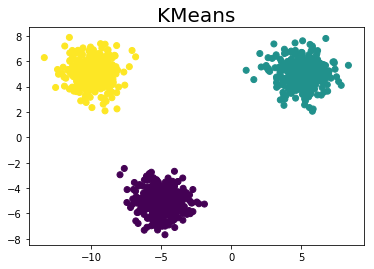

Comparing k-Means clusters against the data:
col_0    0    1    2
row_0               
0      362    0    0
1        0  320    0
2        0    0  318
Number of estimated clusters in Mean-Shift: 3
---------------------------------------------------------------------------


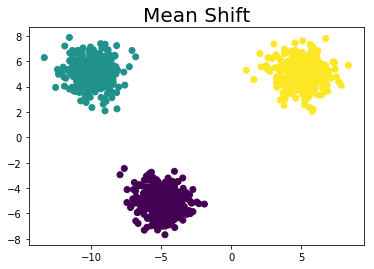

Comparing Mean-Shift clusters against the data:
col_0    0    1    2
row_0               
0      362    0    0
1        0    0  320
2        0  318    0


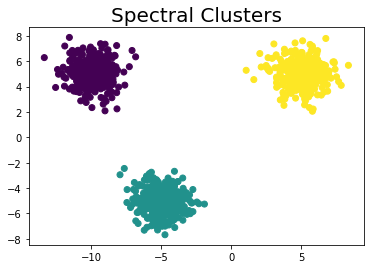

Comparing Spectral Clusters against data:
col_0    0    1    2
row_0               
0        0  362    0
1        0    0  320
2      318    0    0
Estimated number of clusters for Affinity Propagation: 566
---------------------------------------------------------------------------


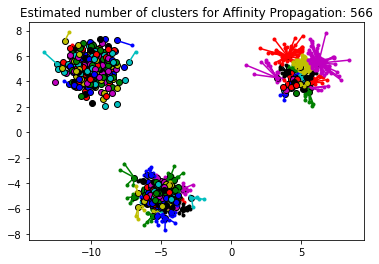

In [46]:
clusters(farx, fary, 3)

As expected, increasing the distance between the blobs made the identification for each cluster a lot more accurate.  There is an issue (maybe) with the mean-shift clustering because the clusters were precisely identified but not accurately.

### Far blobs with high variance

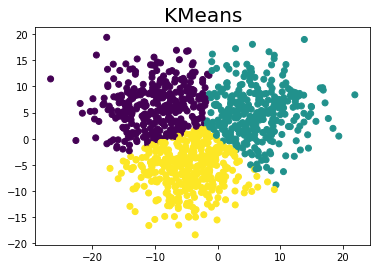

Comparing k-Means clusters against the data:
col_0    0    1    2
row_0               
0       34   23  305
1       25  272   23
2      276    9   33
Number of estimated clusters in Mean-Shift: 2
---------------------------------------------------------------------------


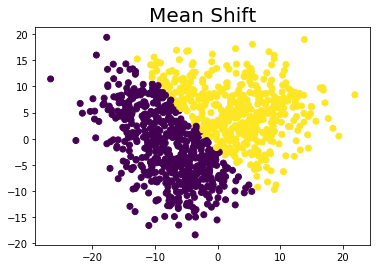

Comparing Mean-Shift clusters against the data:
col_0    0    1
row_0          
0      321   41
1       17  303
2      225   93


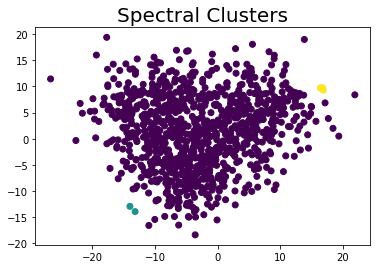

Comparing Spectral Clusters against data:
col_0    0  1  2
row_0           
0      360  2  0
1      317  0  3
2      318  0  0
Estimated number of clusters for Affinity Propagation: 34
---------------------------------------------------------------------------


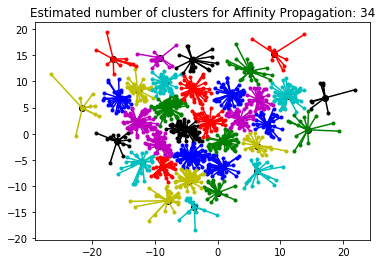

In [47]:
clusters(far_hivarx, far_hivary, 3)

The increased variance only worked (I guess) with the K-Means, all other models were not able to separate the clusters well.  The Mean Shift only determined that there were two clusters to find and even though the number of clusters was set to 3 in the spectral clustering, it essentailly only identified 1.  The affinity propagation created too many clusters but they are very individual (not overlapping much).  It seems like the affinity propagation would allow us to easily select the clusters that identify the correct cluster and allow us to essentially sample down our data using only the most important clusters for our model.

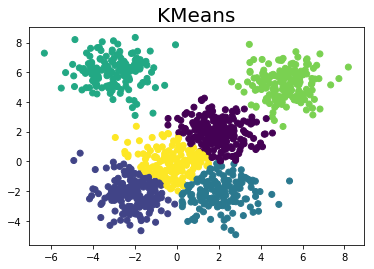

Comparing k-Means clusters against the data:
col_0    0    1    2    3    4    5
row_0                              
0      170    0    0    0    1    5
1        0  163    3    0    0   20
2        5    2  138    0    0    6
3       19    5   12    0    0  133
4        1    0    0    0  164    0
5        0    0    0  153    0    0
Number of estimated clusters in Mean-Shift: 3
---------------------------------------------------------------------------


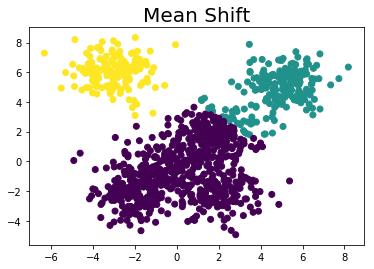

Comparing Mean-Shift clusters against the data:
col_0    0    1    2
row_0               
0      140   36    0
1      186    0    0
2      151    0    0
3      169    0    0
4        0  165    0
5        0    0  153


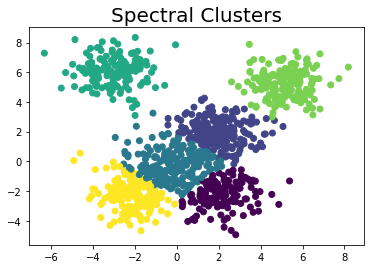

Comparing Spectral Clusters against data:
col_0    0    1    2    3    4    5
row_0                              
0        0  164   11    0    1    0
1        3    0   35    0    0  148
2      126    6   18    0    0    1
3        3   12  150    0    0    4
4        0    3    0    0  162    0
5        0    0    1  152    0    0
Estimated number of clusters for Affinity Propagation: 25
---------------------------------------------------------------------------


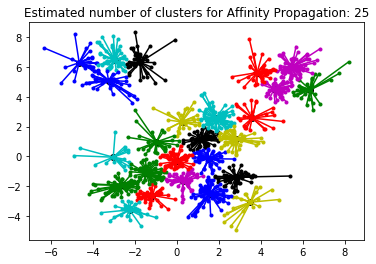

In [48]:
clusters(morex, morey, 6)

Increasing the number of blobs still worked for the K-Means, which seems to be a top performer with the data that I have created here.  The Spectral Cluster also worked well for identifying the 6 clusters.  The mean-shift did not perform so well.

The best clustering method that I have here is going to be the K-Means for outright identifying the clusters using all the data.  The spectral clustering also performed well over all.  I think there is some value to the affinity propagation, especially when considering situations of high variation.  Let's create some blobs with high variance and close distances.

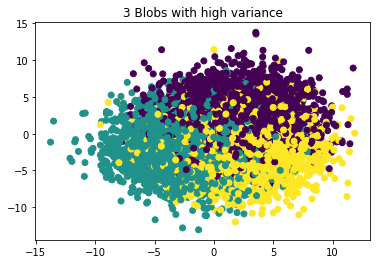

In [51]:
# Increase std for blobs
blobs_center_hivar = [[2, 2], [-2, -2], [2, -2]]

hivarx, hivary = blob_setup(blobs_center_hivar, 3)
plt.scatter(hivarx[:, 0], hivarx[:, 1], c=hivary)
plt.title('3 Blobs with high variance')
plt.show()

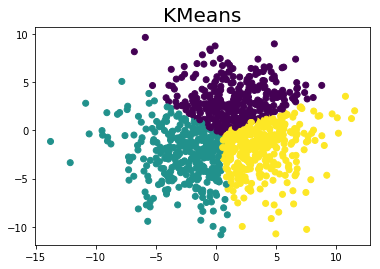

Comparing k-Means clusters against the data:
col_0    0    1    2
row_0               
0      219   35  108
1       34  228   58
2       60   75  183
Number of estimated clusters in Mean-Shift: 1
---------------------------------------------------------------------------


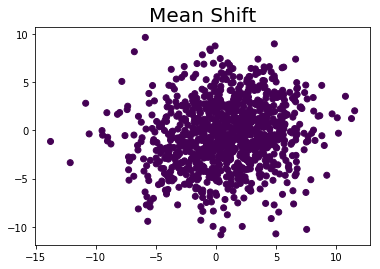

Comparing Mean-Shift clusters against the data:
col_0    0
row_0     
0      362
1      320
2      318


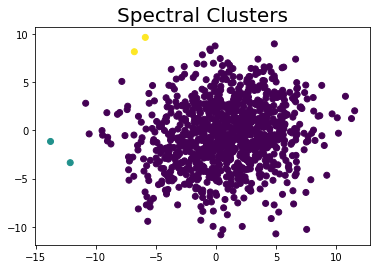

Comparing Spectral Clusters against data:
col_0    0  1  2
row_0           
0      360  0  2
1      318  2  0
2      318  0  0
Estimated number of clusters for Affinity Propagation: 39
---------------------------------------------------------------------------


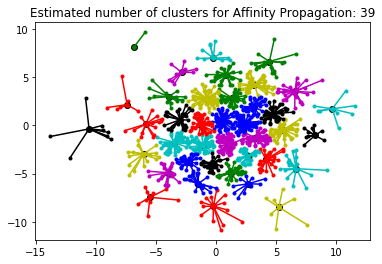

In [52]:
clusters(hivarx, hivary, 3)

The K-means was able to identify these clusters fairly well. The affinity propagation seemed to work well also, by not having too many overlapping exemplar lines.